The idea of that notebook is to have a reproducible benchmark working with the masters version of `pysap` and `modopt` in April 2019. The benchmark will be on speed, for both sparkling and uniform random acquisition schemes, with a brain phantom, for decimated wavelets.

The benchmark will future the algorithms of the abstract submission for SPARS 2019.

Special attention must be taken for Condat. We might need to qualify the benchmark with non reproducible experiments where we set the norm of the linear operator. We also need to take care of the relaxation factor.

In [1]:
# %load_ext autoreload
# %autoreload 2
%matplotlib nbagg

# Third party import
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from tqdm import tqdm_notebook

# Package import
from modopt.math.metrics import ssim
import pysap
from pysap.data import get_sample_data
from mri.numerics.reconstruct import sparse_rec_fista, sparse_rec_pogm, sparse_rec_condatvu
from mri.reconstruct.fourier import NFFT
from mri.reconstruct.utils import generate_operators, convert_mask_to_locations

np.random.seed(0)


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=0.18.0  - required | 1.3.0     installed
numpy          : >=1.11.0  - required | 1.16.3    installed
matplotlib     : >=2.0.0   - required | 3.1.0     installed
future         : >=0.16.0  - required | 0.17.1    installed
astropy        : ==2.0.8   - required | 2.0.8     installed
nibabel        : >=2.1.0   - required | 2.4.0     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.1.5   - requi

#  Loading input data

In [2]:
image = get_sample_data("mri-slice-nifti")
original_image_data = np.copy(image.data)
image.data += np.random.randn(*image.shape) * 20.
image.data = image.data.astype(np.complex128)
mask = get_sample_data("mri-mask")

In [3]:
non_cartesian = True
sparkling = True
opt_results = {}

# Generate the kspace 
From the 2D brain slice and the acquistion mask, we generate the acquisition measurments, the observed kspace. We then reconstruct the zero order solution.

In [4]:
# potential path to sparkling trajectory
sparkling_traj_file_path = '../personal_experiments/2019-Mar-01_N512_nc34_ns3073_OS1_decim64_decay2_tau0.75_nrevol1/samples_SPARKLING_N512_nc34x3073_OS1.mat'

In [5]:
# Generate the subsampled kspace
if non_cartesian:
    if sparkling:
        kspace_loc = scipy.io.loadmat(sparkling_traj_file_path)['samples']
    else:
        kspace_loc = convert_mask_to_locations(mask.data)
    fourier_op = NFFT(samples=kspace_loc, shape=image.shape)
    kspace_data = fourier_op.op(image.data)

    # Zero order solution
    image_rec0 = pysap.Image(data=fourier_op.adj_op(kspace_data), metadata=image.metadata)
else:
    kspace_mask = np.fft.ifftshift(mask.data)
    kspace_data = np.fft.fft2(image.data, norm="ortho") * kspace_mask

    # Get the locations of the kspace samples
    kspace_loc = convert_mask_to_locations(kspace_mask)

    # Zero order solution
    image_rec0 = pysap.Image(data=np.fft.ifft2(kspace_data, norm="ortho"), metadata=image.metadata)

/volatile/home/Zaccharie/workspace/pysap-mri/mri/reconstruct/fourier.py:172: UserWarning: Samples will be normalized between [-0.5; 0.5[
  warnings.warn("Samples will be normalized between [-0.5; 0.5[")
/volatile/home/Zaccharie/workspace/pysap-mri/mri/reconstruct/utils.py:103: UserWarning: Frequency equal to 0.5 will be put in -0.5
  warnings.warn("Frequency equal to 0.5 will be put in -0.5")


# FISTA optimization
We now want to refine the zero order solution using a FISTA optimization.

In [6]:
# Generate operators
gradient_op, linear_op, prox_op, cost_op = generate_operators(
    data=kspace_data,
    wavelet_name="db4",
    samples=kspace_loc,
    nb_scales=4,
    non_cartesian=non_cartesian,
    uniform_data_shape=image.shape,
    gradient_space="synthesis",
)

In [7]:
def objective_cost(x):
    return data_fidelity(x) + sparsity(x)

def sparsity(x):
    return mu * np.sum(np.abs(x))

def data_fidelity(x):
    return 0.5 * np.linalg.norm(gradient_op.op(x) - kspace_data)**2

def objective_cost_condat(x):
    return data_fidelity_condat(x) + sparsity_condat(x)

def sparsity_condat(x):
    return mu * np.sum(np.abs(linear_op.op(x)))

def data_fidelity_condat(x):
    return 0.5 * np.linalg.norm(fourier_op.op(x) - kspace_data)**2

In [8]:
def nrmse(x):
    return np.linalg.norm(x - original_image_data) / np.mean(original_image_data)

def nrmse_pogm(x):
    im = linear_op.adj_op(x)
    return np.linalg.norm(im - original_image_data) / np.mean(original_image_data)

In [9]:
metrics_ = {
    "cost": {"metric": objective_cost, "mapping": {"z_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
    "nrmse": {"metric": nrmse, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
}

metrics_pogm = {
    "cost": {"metric": objective_cost, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
    "nrmse": {"metric": nrmse_pogm, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
}

metrics_condat = {
    "cost": {"metric": objective_cost_condat, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
    "nrmse": {"metric": nrmse, "mapping": {"x_new": "x"}, "cst_kwargs": {}, "early_stopping": False},
}

In [10]:
mu = 80

In [11]:
max_iter = 1000
convergence_pot = max_iter >= 500

In [12]:
# Start the FISTA reconstruction
cost_op = None
x_final, transform, costs, metrics = sparse_rec_fista(
    gradient_op,
    linear_op,
    prox_op,
    cost_op,
    mu=mu,
    lambda_init=1.0,
    max_nb_of_iter=max_iter,
    verbose=1,
    metrics=metrics_,
    metric_call_period=20,
    **{"restart_strategy": "greedy", "xi_restart": 0.96, "s_greedy": 1.1},
)
image_rec = pysap.Image(data=np.abs(x_final))


  _____             ____     _____      _
 |" ___|    ___    / __"| u |_ " _| U  /"\  u
U| |_  u   |_"_|  <\___ \/    | |    \/ _ \/
\|  _|/     | |    u___) |   /| |\   / ___ \\
 |_|      U/| |\u  |____/>> u |_|U  /_/   \_\\
 )(\\\,-.-,_|___|_,-.)(  (__)_// \\\_  \\\    >>
(__)(_/ \_)-' '-(_/(__)    (__) (__)(__)  (__)
    
 - mu:  80
 - lipschitz constant:  95.51082260788888
 - data:  (512, 512)
 - wavelet:  <mri.reconstruct.linear.Wavelet2 object at 0x7ff32f191c50> - 4
 - max iterations:  1000
 - image variable shape:  (512, 512)
 - alpha variable shape:  (262144,)
----------------------------------------
Starting optimization...


100% (1000 of 1000) |####################| Elapsed Time: 0:05:01 Time:  0:05:01


 - converged:  False
Done.
Execution time:  9455.867389000001  seconds
----------------------------------------


In [13]:
if convergence_pot:
    opt_results[mu] = {
        "nrmse": metrics['nrmse']['values'][-1],
        "cost": metrics['cost']['values'][-1],
    }
    print(opt_results)

{80: {'nrmse': 119.97750051074178, 'cost': 137722835.7443366}}


In [14]:
max_iter = 300

In [15]:
# FISTA rec
params = {
    r"FISTA-BT": ({}, "black"),
    r"FISTA-CD, $a = 20$": ({"a_cd": 20}, "blue"),    
    r"Rada-FISTA": (
        {"p_lazy": (1/30), "q_lazy": (1/10), "restart_strategy": "adaptive", "xi_restart": 0.96}, 
        "orange",
    ),
    r"greedy FISTA": (
        {"restart_strategy": "greedy", "xi_restart": 0.96, "s_greedy": 1.1}, 
        "violet",
    ),
}

res_param = {}
for param_name, (param, _) in tqdm_notebook(params.items(), desc='FISTA variations'):
    _, _, _, metrics = sparse_rec_fista(
        gradient_op,
        linear_op,
        prox_op,
        None,
        mu=mu,
        lambda_init=1.0,
        max_nb_of_iter=max_iter,
        verbose=0,
        metrics=metrics_,
        metric_call_period=1,
        **param,
    )
    res_param[param_name] = {
        "cost": np.array(metrics['cost']['values']),
        "nrmse": np.array(metrics['nrmse']['values']),
    }

# POGM rec
pogm_name = r"POGM'"
params[pogm_name] = (None, "red")

_, _, metrics = sparse_rec_pogm(
    gradient_op,
    linear_op,
    prox_op,
    mu=mu,
    max_nb_of_iter=max_iter,
    verbose=0,
    metrics=metrics_pogm,
    metric_call_period=1,
)
res_param[pogm_name] = {
    "cost": np.array(metrics['cost']['values']),
    "nrmse": np.array(metrics['nrmse']['values']),
}

100% (300 of 300) |######################| Elapsed Time: 0:02:10 Time:  0:02:10
100% (300 of 300) |######################| Elapsed Time: 0:02:07 Time:  0:02:07
100% (300 of 300) |######################| Elapsed Time: 0:02:08 Time:  0:02:08
100% (300 of 300) |######################| Elapsed Time: 0:02:27 Time:  0:02:27


100% (300 of 300) |######################| Elapsed Time: 0:02:14 Time:  0:02:14


In [16]:
# Condat rec
gradient_op_condat, linear_op_condat, prox_op_condat, cost_op_condat = generate_operators(
    data=kspace_data,
    wavelet_name="db4",
    samples=kspace_loc,
    nb_scales=4,
    non_cartesian=non_cartesian,
    uniform_data_shape=image.shape,
    gradient_space="analysis",
)

condat_name = r"Condat"
params[condat_name] = (None, "green")

_, _, _, metrics = sparse_rec_condatvu(
    gradient_op_condat,
    linear_op_condat,
    prox_op_condat,
    cost_op=None,
    mu=mu,
    sigma=10,
    relaxation_factor=0.5,
    max_nb_of_iter=max_iter,
    verbose=0,
    metrics=metrics_condat,
    metric_call_period=1,
)
res_param[condat_name] = {
    "cost": np.array(metrics['cost']['values']),
    "nrmse": np.array(metrics['nrmse']['values']),
}

100% (300 of 300) |######################| Elapsed Time: 0:02:15 Time:  0:02:15


<IPython.core.display.Javascript object>


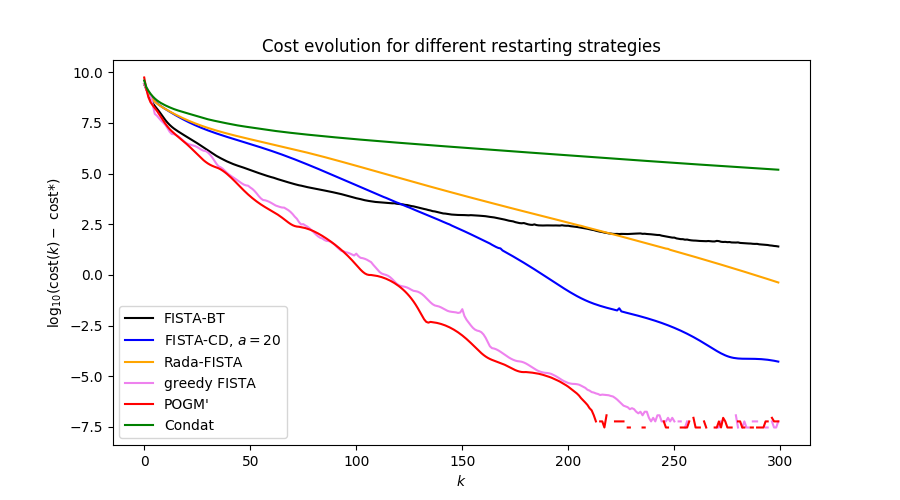

/volatile/home/Zaccharie/workspace/pysap-mri/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


Text(0, 0.5, '$\\log_{10}($cost$(k) -$ cost$*)$')

In [19]:
metric_name = "cost"
plt.figure(figsize=(9, 5))
for param_name, param_res in res_param.items():
    plt.plot(
        np.log10(np.abs(np.array(param_res[metric_name] - opt_results[mu][metric_name]))), 
        label=param_name, 
        color=params[param_name][1],
    )
plt.legend()
plt.title(r"Cost evolution for different restarting strategies")
plt.xlabel(r"$k$")
plt.ylabel(r"$\log_{10}($cost$(k) -$ cost$*)$")